In [30]:
import pandas as pd
import numpy as np
import os
import csv
import datetime
from tqdm.notebook import tqdm, trange

from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset # used load data
import torch.optim as optim

from transformers.data.processors.utils import InputExample, InputFeatures
from transformers import (AdamW,
                          get_linear_schedule_with_warmup,
                          get_cosine_with_hard_restarts_schedule_with_warmup)

from transformers import (CamembertConfig,
                          CamembertForSequenceClassification,
                          CamembertTokenizer)


In [4]:
path_data="data/"

In [5]:
# modified from glue.py and utils.py

class InputExample(object):

    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"

    
class DataProcessor():
    
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8-sig") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                line = list(cell for cell in line)
                lines.append(line)
            return lines

        
        
    def get_example_from_tensor_dict(self, tensor_dict):
        """See base class."""
        return InputExample(tensor_dict['ID'].numpy(),
                            tensor_dict['question'].numpy().decode('utf-8'),
                            str(tensor_dict['intention'].numpy()))

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")
    
    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "test.tsv")), "test")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_labels(self):
        """See base class."""
        return [str(j) for j in range(51)]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                print(line)
                continue
            guid = "%s-%s" % (set_type, line[0])
            if len(line) == 3:
                utterance = line[1]
                label = line[2]
                examples.append(InputExample(guid=guid, text_a=utterance, text_b=None, label=label))
            else:
                utterance = line[1]
                examples.append(InputExample(guid=guid, text_a=utterance, text_b=None, label="0"))
        return examples


def convert_examples_to_features(examples,
                                 tokenizer,
                                 max_length=512,
                                 label_list=None,
                                      pad_on_left=False,
                                      pad_token=0,
                                      pad_token_segment_id=0,
                                      mask_padding_with_zero=True):
    """
    Loads a data file into a list of ``InputFeatures``

    Args:
        examples: List of ``InputExamples`` or ``tf.data.Dataset`` containing the examples.
        tokenizer: Instance of a tokenizer that will tokenize the examples
        max_length: Maximum example length
        label_list: List of labels. Can be obtained from the processor using the ``processor.get_labels()`` method
        pad_on_left: If set to ``True``, the examples will be padded on the left rather than on the right (default)
        pad_token: Padding token
        pad_token_segment_id: The segment ID for the padding token (It is usually 0, but can vary such as for XLNet where it is 4)
        mask_padding_with_zero: If set to ``True``, the attention mask will be filled by ``1`` for actual values
            and by ``0`` for padded values. If set to ``False``, inverts it (``1`` for padded values, ``0`` for
            actual values)

    Returns:
        If the ``examples`` input is a ``tf.data.Dataset``, will return a ``tf.data.Dataset``
        containing the task-specific features. If the input is a list of ``InputExamples``, will return
        a list of task-specific ``InputFeatures`` which can be fed to the model.

    """

    processor = DataProcessor()
    if label_list is None:
        label_list = processor.get_labels()

    label_map = {label: i for i, label in enumerate(label_list)}
    print(label_map)

    features = []
    for (ex_index, example) in enumerate(examples):
        if ex_index % 10000 == 0:
            print("Writing example %d" % (ex_index))

        inputs = tokenizer.encode_plus(
            example.text_a,
            example.text_b,
            add_special_tokens=True,
            max_length=max_length,
        )
        input_ids, token_type_ids = inputs["input_ids"], inputs["token_type_ids"]

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        attention_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            attention_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + attention_mask
            token_type_ids = ([pad_token_segment_id] * padding_length) + token_type_ids
        else:
            input_ids = input_ids + ([pad_token] * padding_length)
            attention_mask = attention_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
            token_type_ids = token_type_ids + ([pad_token_segment_id] * padding_length)

        assert len(input_ids) == max_length, "Error with input length {} vs {}".format(len(input_ids), max_length)
        assert len(attention_mask) == max_length, "Error with input length {} vs {}".format(len(attention_mask), max_length)
        assert len(token_type_ids) == max_length, "Error with input length {} vs {}".format(len(token_type_ids), max_length)

        label = label_map[example.label]
            
        #if ex_index < 5:
            #print("*** Example ***")
            #print("guid: %s" % (example.guid))
            #print("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            #print("attention_mask: %s" % " ".join([str(x) for x in attention_mask]))
            #print("token_type_ids: %s" % " ".join([str(x) for x in token_type_ids]))
            #print("label: %s (id = %d)" % (example.label, label))

        features.append(
                InputFeatures(input_ids=input_ids,
                              attention_mask=attention_mask,
                              token_type_ids=token_type_ids,
                              label=label))

    return features

In [47]:
def load_and_cache_examples(tokenizer, 
                            max_seq_length,
                            data_dir,
                            which_data="train",
                            overwrite_cache = False,
                            verbose=1):

    processor = DataProcessor()
    # Load data features from cache or dataset file
    cached_features_file = os.path.join(data_dir, 'cached_{}_{}'.format(which_data,
                                                                        str(max_seq_length)))
    if os.path.exists(cached_features_file) and not overwrite_cache:
        if verbose > 0:
            print("Loading features from cached file %s" % cached_features_file)
        features = torch.load(cached_features_file)
    else:
        if verbose > 0:
            print("Creating features from dataset file at %s" % data_dir)
        label_list = processor.get_labels()
        
        if which_data == "train":
            examples = processor.get_train_examples(data_dir)
        elif which_data == "test":
            examples = processor.get_test_examples(data_dir)
        elif which_data == "dev":
            examples = processor.get_dev_examples(data_dir)
        
        features = convert_examples_to_features(examples,
                                                tokenizer,
                                                label_list=label_list,
                                                max_length=max_seq_length,
                                                pad_on_left=False,
                                                pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                                pad_token_segment_id=0,
        )
        if verbose > 0:
            print("Saving features into cached file %s" % cached_features_file)
        torch.save(features, cached_features_file)

    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels = torch.tensor([f.label for f in features], dtype=torch.long)

    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
    return dataset


def train(model, train_dataset, tokenizer, num_train_epochs, train_batch_size, learning_rate, adam_epsilon=1e-8,
          logging_steps=None, gradient_accumulation_steps=1, max_grad_norm=1.0, weight_decay=0.0,
          warmup_steps=0, save_steps=-1, output_dir=None, evaluate_during_training=False,
          seed=None, max_steps=-1, num_cycles=1.0):
    
    """ Train the model """
    if output_dir is None:
        output_dir = "model_" + str(datetime.datetime.now()).split(".")[0].replace(" ","_") + "/"
        
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=train_batch_size)
    
    if logging_steps is None:
        logging_steps = len(train_dataloader) // (gradient_accumulation_steps * 5)
        
    if max_steps > 0:
        t_total = max_steps
        num_train_epochs = max_steps // (len(train_dataloader) // gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // gradient_accumulation_steps * num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    
    # pas besoin de la partie custom ci-dessous à priori
    
    #no_decay = ['bias', 'LayerNorm.weight']
    #optimizer_grouped_parameters = [
    #    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
    #    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    #    ]
    
    # change l'optimizer pour voir
    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon) # optimizer_grouped_parameters
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) #eps=adam_epsilon , momentum=0.9
    #scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)
    scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer,
                                                                   num_warmup_steps=warmup_steps,
                                                                   num_training_steps=t_total,
                                                                   num_cycles=num_cycles)
    #for i, tensor in enumerate(model.parameters()):
    #    if i > 1:
    #        tensor.requires_grad = False

    # Train!
    print("***** Running training *****")
    print("  Num examples = %d" % len(train_dataset))
    print("  Num Epochs = %d" % num_train_epochs)
    print(" Batch size = %d" % train_batch_size)
    print("  Total train batch size (w. parallel, distributed & accumulation) = %d" %
                   train_batch_size * gradient_accumulation_steps)
    print("  Gradient Accumulation steps = %d" % gradient_accumulation_steps)
    print("  Total optimization steps = %d" % t_total)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(int(num_train_epochs), desc="Epoch")
    if seed is not None:
        set_seed(seed)
        
    for epoch, _ in enumerate(train_iterator):
        # print("Epoch %d / %d" % (epoch, num_train_epochs))
        epoch_iterator = train_dataloader
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'labels':         batch[3]}
            inputs['token_type_ids'] = batch[2] #or None
            optimizer.zero_grad()

            outputs = model(**inputs)
            #print(outputs)
            #print(outputs[0].size())
            #print(outputs[1].size())
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)
            #print(loss)
            
            if gradient_accumulation_steps > 1:
                loss = loss / gradient_accumulation_steps

            loss.backward()

            tr_loss += loss.item()
            print("lr:",scheduler.get_lr()[0], "loss:", loss.item())
            if (step + 1) % gradient_accumulation_steps == 0:
                #params = list(model.parameters())[:1]
                #print(params)
                #print([torch.sum(par, 0) for par in params])
                #print([par.size() for par in params])
                #print([par.grad for par in params])
                #print([torch.sum(par.grad, 0) for par in params])
                #print([torch.sum(par.grad, 1) for par in params])
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

                
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if logging_steps > 0 and global_step % logging_steps == 0:
                    print("\n\nEval")
                    # Log metrics
                    dict_print = {'step':global_step,
                                  'lr': scheduler.get_lr()[0],
                                  'tr_loss': (tr_loss - logging_loss)/logging_steps}
                    if evaluate_during_training:
                        results = evaluate(model, tokenizer, eval_output_dir=output_dir, verbose=-1)
                        for key, value in results.items():
                            dict_print['eval_{}'.format(key)] = value
                    print(dict_print)
                    logging_loss = tr_loss

                if save_steps > 0 and global_step % save_steps == 0:
                    # Save model checkpoint
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    save_model_dir = os.path.join(output_dir, 'checkpoint-{}'.format(global_step))
                    os.makedirs(save_model_dir)
                    model.save_pretrained(save_model_dir)
                    #torch.save(args, os.path.join(output_dir, 'training_args.bin'))
                    print("Saving model checkpoint to %s" % save_model_dir)

            if max_steps > 0 and global_step > max_steps:
                #epoch_iterator.close() #deleted since no tqdm anymore
                break
                
        if max_steps > 0 and global_step > max_steps:
            train_iterator.close()
            break

    if global_step == 0:
        global_step= 1

    return global_step, tr_loss / global_step


def evaluate(model, tokenizer, eval_batch_size=8, prefix="", eval_output_dir=None,
             verbose=1):
    
    #results = {}
    eval_dataset = load_and_cache_examples(tokenizer=tokenizer, max_seq_length=128, data_dir="data/",
                                           which_data="test", verbose=verbose)
    
    eval_batch_size = eval_batch_size
    # Note that DistributedSampler samples randomly
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=eval_batch_size)
    
    # Eval!
    if verbose > 0:
        print("***** Running evaluation {} *****".format(prefix))
        print("  Num examples = %d", len(eval_dataset))
        print("  Batch size = %d", eval_batch_size)
        
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'labels':         batch[3]}
            inputs['token_type_ids'] = batch[2] #or None
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]
            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    preds_class = np.argmax(preds, axis=1)
    acc = accuracy_score(out_label_ids, preds_class)
    
    result = {"val_loss": eval_loss, "val_acc" : acc}
    #results.update(result)

    if eval_output_dir is not None:
        if not os.path.exists(eval_output_dir):
            os.makedirs(eval_output_dir)
        
        output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
        with open(output_eval_file, "a") as writer:
            writer.write("***** Eval results {} *****".format(prefix))
            for key in sorted(result.keys()):
                writer.write("  %s = %s" % (key, str(result[key])))
            writer.write("\n")

    return result



In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [52]:
num_labels=51 # 1081
model_name="camembert-base"

config = CamembertConfig.from_pretrained(model_name,
                                         num_labels=num_labels,
                                         finetuning_task="classification")

In [53]:
tokenizer = CamembertTokenizer.from_pretrained(model_name,
                                               do_lower_case=True)

In [54]:
model = CamembertForSequenceClassification.from_pretrained(model_name, config=config)
model = model.to(device)


In [55]:
# rmk : we can see all sequences of tokens begin with 5 and end with 6
train_dataset = load_and_cache_examples(tokenizer=tokenizer, max_seq_length=128, data_dir="data/", which_data="train")


Loading features from cached file data/cached_train_128


In [17]:
l = [torch.sum(train_dataset[i][1]) for i in range(len(train_dataset))]

In [20]:
import matplotlib.pyplot as plt

[]

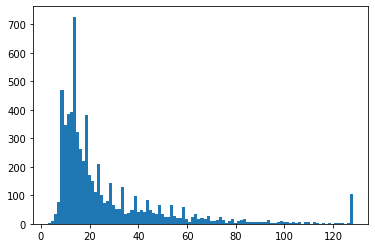

In [22]:
plt.hist(l, bins=100)
plt.plot()

In [23]:
dev_dataset = load_and_cache_examples(tokenizer=tokenizer, max_seq_length=128, data_dir="data/", which_data="dev")


Loading features from cached file data/cached_dev_128


[]

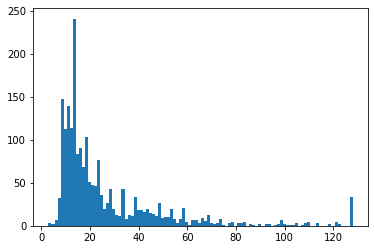

In [24]:
l = [torch.sum(train_dataset[i][1]) for i in range(len(dev_dataset))]
plt.hist(l, bins=100)
plt.plot()

In [25]:
len(dev_dataset)

2035

In [56]:
train(model=model, train_dataset=train_dataset, tokenizer=tokenizer, train_batch_size=32,
      learning_rate=3e-5, num_train_epochs=10, evaluate_during_training=True, logging_steps=200,
      max_grad_norm=1.0, save_steps=-1, num_cycles=5.0) #  , max_steps=3


***** Running training *****
  Num examples = 6422
  Num Epochs = 10
 Batch size = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2010


lr: 3e-05 loss: 3.8994977474212646
lr: 2.999954195653399e-05 loss: 3.8898026943206787
lr: 2.9998167854109796e-05 loss: 3.8786516189575195
lr: 2.999587777664724e-05 loss: 3.874788761138916
lr: 2.9992671864006992e-05 loss: 3.8684329986572266
lr: 2.9988550311982027e-05 loss: 3.7951114177703857
lr: 2.9983513372285672e-05 loss: 3.8379433155059814
lr: 2.9977561352536243e-05 loss: 3.810689687728882
lr: 2.997069461623824e-05 loss: 3.7759265899658203
lr: 2.9962913582760155e-05 loss: 3.7477684020996094
lr: 2.9954218727308853e-05 loss: 3.7648766040802
lr: 2.9944610580900574e-05 loss: 3.854386806488037
lr: 2.9934089730328472e-05 loss: 3.7600817680358887
lr: 2.9922656818126796e-05 loss: 3.619133710861206
lr: 2.991031254253164e-05 loss: 3.625623941421509
lr: 2.9897057657438315e-05 loss: 3.742122173309326
lr: 2.988289297235528e-05 loss: 3.693572521209717
lr: 2.9867819352354736e-05 loss: 3.7593836784362793
lr: 2.9851837718019762e-05 loss: 3.545797109603882
lr: 2.983494904538813e-05 loss: 3.59793472290

lr: 1.9612952007985554e-05 loss: 3.141493320465088
lr: 1.9501269525005113e-05 loss: 2.9826714992523193
lr: 1.9389312138412048e-05 loss: 3.0562903881073
lr: 1.9277086685719606e-05 loss: 2.9038913249969482
lr: 1.9164600020812507e-05 loss: 3.13905668258667
lr: 1.9051859013528333e-05 loss: 3.025085926055908
lr: 1.8938870549237976e-05 loss: 2.646761178970337
lr: 1.8825641528425147e-05 loss: 2.9008121490478516
lr: 1.8712178866264932e-05 loss: 2.7262747287750244
lr: 1.859848949220147e-05 loss: 3.090519905090332
lr: 1.848458034952475e-05 loss: 3.1595470905303955
lr: 1.8370458394946576e-05 loss: 3.274609327316284
lr: 1.8256130598175702e-05 loss: 2.900063991546631
lr: 1.8141603941492165e-05 loss: 3.274812698364258
lr: 1.802688541932087e-05 loss: 2.8855886459350586
lr: 1.7911982037804417e-05 loss: 2.999274969100952
lr: 1.779690081437522e-05 loss: 2.902615785598755
lr: 1.768164877732694e-05 loss: 3.0955069065093994
lr: 1.756623296538525e-05 loss: 2.7919762134552
lr: 1.7450660427277957e-05 loss: 2.


{'step': 200, 'lr': 1.5117222413285759e-05, 'tr_loss': 3.25203120470047, 'eval_val_loss': 2.7574466573658274, 'eval_val_acc': 0.3493150684931507}
lr: 1.5117222413285759e-05 loss: 2.7136170864105225
lr: 1.5e-05 loss: 2.511777639389038
lr: 1.488277758671424e-05 loss: 2.877239465713501
lr: 1.4765562332489879e-05 loss: 2.8443100452423096
lr: 1.4648361395951101e-05 loss: 2.5716476440429688
lr: 1.453118193484764e-05 loss: 2.6022329330444336
lr: 1.441403110561771e-05 loss: 2.4898176193237305
lr: 1.4296916062950905e-05 loss: 2.9614145755767822
lr: 1.4179843959351214e-05 loss: 3.109053134918213
lr: 1.4062821944700258e-05 loss: 2.7403931617736816
lr: 1.3945857165820612e-05 loss: 2.680091381072998
lr: 1.3828956766039278e-05 loss: 2.5370399951934814
lr: 1.371212788475151e-05 loss: 2.292161226272583
lr: 1.359537765698474e-05 loss: 2.4624736309051514
lr: 1.3478713212962825e-05 loss: 2.526261329650879
lr: 1.3362141677670611e-05 loss: 2.650351047515869
lr: 1.3245670170418764e-05 loss: 2.5551509857177

lr: 8.389867868587847e-07 loss: 2.4385290145874023
lr: 8.0076487064349e-07 loss: 2.9543426036834717
lr: 7.634101366779755e-07 loss: 2.8176615238189697
lr: 7.269248663078187e-07 loss: 3.1260740756988525
lr: 6.913112877783146e-07 loss: 2.7649805545806885
lr: 6.565715760983875e-07 loss: 2.824313163757324
lr: 6.227078529077651e-07 loss: 2.608370542526245
lr: 5.89722186347399e-07 loss: 2.652054786682129
lr: 5.576165909331582e-07 loss: 2.748356342315674
lr: 5.263930274328061e-07 loss: 2.4118731021881104
lr: 4.960534027462387e-07 loss: 2.4062788486480713
lr: 4.6659956978904405e-07 loss: 2.6877706050872803
lr: 4.38033327379313e-07 loss: 2.752072811126709
lr: 4.1035642012780484e-07 loss: 2.2659661769866943
lr: 3.8357053833139034e-07 loss: 2.5313711166381836
lr: 3.5767731786982117e-07 loss: 2.5465307235717773
lr: 3.326783401058231e-07 loss: 2.504688024520874
lr: 3.085751317885199e-07 loss: 2.5700783729553223
lr: 2.8536916496018803e-07 loss: 2.8314921855926514
lr: 2.630618568663584e-07 loss: 2.23


{'step': 400, 'lr': 1.8321458902048616e-09, 'tr_loss': 2.6493070411682127, 'eval_val_loss': 2.5445440960167653, 'eval_val_acc': 0.4576587795765878}
lr: 1.8321458902048616e-09 loss: 2.643852710723877
lr: 4.580434660111932e-10 loss: 2.702704429626465
lr: 3e-05 loss: 2.7976865768432617
lr: 2.999954195653399e-05 loss: 2.641946315765381
lr: 2.9998167854109796e-05 loss: 2.690819263458252
lr: 2.999587777664724e-05 loss: 2.423555850982666
lr: 2.9992671864006992e-05 loss: 2.4039835929870605
lr: 2.9988550311982027e-05 loss: 2.873582124710083
lr: 2.9983513372285672e-05 loss: 2.932002067565918
lr: 2.9977561352536243e-05 loss: 2.6980550289154053
lr: 2.997069461623824e-05 loss: 2.69049072265625
lr: 2.9962913582760155e-05 loss: 2.165360927581787
lr: 2.9954218727308853e-05 loss: 2.627767324447632
lr: 2.9944610580900574e-05 loss: 2.307570695877075
lr: 2.9934089730328472e-05 loss: 2.4167251586914062
lr: 2.9922656818126796e-05 loss: 2.465825319290161
lr: 2.991031254253164e-05 loss: 2.2763400077819824
lr

lr: 2.0167002754265005e-05 loss: 1.7704766988754272
lr: 2.0056796749872762e-05 loss: 2.3569536209106445
lr: 1.9946281914452498e-05 loss: 2.048210859298706
lr: 1.9835464997417313e-05 loss: 2.1447672843933105
lr: 1.9724352766629157e-05 loss: 2.5132648944854736
lr: 1.9612952007985554e-05 loss: 2.1755142211914062
lr: 1.9501269525005113e-05 loss: 1.8429111242294312
lr: 1.938931213841204e-05 loss: 1.7633916139602661
lr: 1.9277086685719612e-05 loss: 1.940122127532959
lr: 1.91646000208125e-05 loss: 2.11788272857666
lr: 1.9051859013528333e-05 loss: 2.011408805847168
lr: 1.8938870549237973e-05 loss: 1.9885951280593872
lr: 1.8825641528425153e-05 loss: 2.0904362201690674
lr: 1.8712178866264935e-05 loss: 2.0205647945404053
lr: 1.8598489492201472e-05 loss: 2.722196340560913
lr: 1.848458034952475e-05 loss: 2.281071424484253
lr: 1.8370458394946576e-05 loss: 1.749297022819519
lr: 1.825613059817571e-05 loss: 1.8995946645736694
lr: 1.8141603941492158e-05 loss: 2.2822086811065674
lr: 1.8026885419320873e-0


{'step': 600, 'lr': 1.5351638604048917e-05, 'tr_loss': 2.3106106197834015, 'eval_val_loss': 2.0587230867414332, 'eval_val_acc': 0.5603985056039851}
lr: 1.5351638604048917e-05 loss: 2.11313796043396
lr: 1.5234437667510115e-05 loss: 2.079392433166504
lr: 1.5117222413285762e-05 loss: 2.5158443450927734
lr: 1.5e-05 loss: 2.1724960803985596
lr: 1.4882777586714254e-05 loss: 2.104306697845459
lr: 1.4765562332489879e-05 loss: 2.03843092918396
lr: 1.4648361395951088e-05 loss: 2.0526037216186523
lr: 1.453118193484764e-05 loss: 1.772128701210022
lr: 1.4414031105617723e-05 loss: 1.7104392051696777
lr: 1.4296916062950898e-05 loss: 1.9053449630737305
lr: 1.4179843959351207e-05 loss: 2.4754979610443115
lr: 1.4062821944700265e-05 loss: 2.0161631107330322
lr: 1.3945857165820612e-05 loss: 2.251940965652466
lr: 1.3828956766039278e-05 loss: 1.751309871673584
lr: 1.371212788475151e-05 loss: 1.6622234582901
lr: 1.3595377656984737e-05 loss: 1.8342458009719849
lr: 1.3478713212962832e-05 loss: 2.1171216964721

lr: 9.180227759942045e-07 loss: 2.0019166469573975
lr: 8.780735510173316e-07 loss: 2.4437618255615234
lr: 8.389867868587847e-07 loss: 2.142629861831665
lr: 8.0076487064349e-07 loss: 2.25730562210083
lr: 7.634101366779755e-07 loss: 1.7647266387939453
lr: 7.269248663078187e-07 loss: 1.7709234952926636
lr: 6.913112877783146e-07 loss: 1.7446008920669556
lr: 6.565715760983892e-07 loss: 2.2036612033843994
lr: 6.227078529077634e-07 loss: 2.3322224617004395
lr: 5.89722186347399e-07 loss: 1.7101751565933228
lr: 5.576165909331582e-07 loss: 1.600913643836975
lr: 5.263930274328077e-07 loss: 2.2469913959503174
lr: 4.960534027462387e-07 loss: 2.0486159324645996
lr: 4.6659956978904405e-07 loss: 1.8746590614318848
lr: 4.38033327379313e-07 loss: 1.9268059730529785
lr: 4.1035642012780484e-07 loss: 1.5947704315185547
lr: 3.8357053833139034e-07 loss: 1.7821272611618042
lr: 3.576773178698195e-07 loss: 1.755131483078003
lr: 3.3267834010582475e-07 loss: 1.8555731773376465
lr: 3.085751317885199e-07 loss: 2.03


{'step': 800, 'lr': 7.328135993011631e-09, 'tr_loss': 1.9463878750801087, 'eval_val_loss': 1.9291358053387695, 'eval_val_acc': 0.6133250311332503}
lr: 7.328135993011631e-09 loss: 2.445767641067505
lr: 4.1222233527615786e-09 loss: 1.94623601436615
lr: 1.8321458902048616e-09 loss: 1.905029535293579
lr: 4.580434660111932e-10 loss: 2.5703797340393066
lr: 3e-05 loss: 1.9817432165145874
lr: 2.999954195653399e-05 loss: 1.9042155742645264
lr: 2.9998167854109796e-05 loss: 1.9069492816925049
lr: 2.999587777664724e-05 loss: 1.3235276937484741
lr: 2.9992671864006992e-05 loss: 1.8423658609390259
lr: 2.9988550311982024e-05 loss: 2.256005048751831
lr: 2.9983513372285672e-05 loss: 1.5807685852050781
lr: 2.9977561352536243e-05 loss: 2.000577211380005
lr: 2.997069461623824e-05 loss: 1.6932159662246704
lr: 2.9962913582760155e-05 loss: 1.733465552330017
lr: 2.9954218727308853e-05 loss: 1.7836902141571045
lr: 2.9944610580900574e-05 loss: 2.0066723823547363
lr: 2.9934089730328475e-05 loss: 1.97071528434753

lr: 2.0386461367029363e-05 loss: 1.7226585149765015
lr: 2.027689319707716e-05 loss: 1.582245945930481
lr: 2.0167002754265005e-05 loss: 1.5828804969787598
lr: 2.005679674987277e-05 loss: 1.5434231758117676
lr: 1.9946281914452505e-05 loss: 1.9564149379730225
lr: 1.9835464997417313e-05 loss: 1.4157931804656982
lr: 1.9724352766629157e-05 loss: 1.6475751399993896
lr: 1.9612952007985554e-05 loss: 1.579906702041626
lr: 1.9501269525005113e-05 loss: 1.483141303062439
lr: 1.938931213841204e-05 loss: 1.6036076545715332
lr: 1.9277086685719606e-05 loss: 1.9456888437271118
lr: 1.916460002081252e-05 loss: 1.6984808444976807
lr: 1.9051859013528323e-05 loss: 1.7289981842041016
lr: 1.8938870549237963e-05 loss: 1.6166366338729858
lr: 1.8825641528425153e-05 loss: 1.4063754081726074
lr: 1.8712178866264935e-05 loss: 1.3733160495758057
lr: 1.8598489492201472e-05 loss: 1.6373162269592285
lr: 1.848458034952475e-05 loss: 2.349170684814453
lr: 1.8370458394946576e-05 loss: 1.4723294973373413
lr: 1.82561305981757e


{'step': 1000, 'lr': 1.558596889438228e-05, 'tr_loss': 1.753317340016365, 'eval_val_loss': 1.657076544726073, 'eval_val_acc': 0.6706102117061021}
lr: 1.558596889438228e-05 loss: 1.1052862405776978
lr: 1.5468818065152374e-05 loss: 1.3753139972686768
lr: 1.5351638604048917e-05 loss: 1.6101998090744019
lr: 1.5234437667510125e-05 loss: 1.7813961505889893
lr: 1.5117222413285762e-05 loss: 1.9557911157608032
lr: 1.5e-05 loss: 1.3242790699005127
lr: 1.488277758671424e-05 loss: 1.9400802850723267
lr: 1.4765562332489879e-05 loss: 1.407860517501831
lr: 1.4648361395951111e-05 loss: 2.0062034130096436
lr: 1.4531181934847649e-05 loss: 1.4594990015029907
lr: 1.44140311056177e-05 loss: 1.6171696186065674
lr: 1.4296916062950888e-05 loss: 1.667248010635376
lr: 1.4179843959351197e-05 loss: 1.669864535331726
lr: 1.4062821944700265e-05 loss: 1.2722887992858887
lr: 1.3945857165820612e-05 loss: 1.3222836256027222
lr: 1.3828956766039278e-05 loss: 1.2336902618408203
lr: 1.371212788475153e-05 loss: 1.137340664

lr: 1.0430205553937072e-06 loss: 1.6889115571975708
lr: 1.0004987966892121e-06 loss: 0.9739058017730713
lr: 9.588320219918729e-07 loss: 1.0533488988876343
lr: 9.180227759942012e-07 loss: 1.5810863971710205
lr: 8.780735510173332e-07 loss: 1.7274752855300903
lr: 8.389867868587847e-07 loss: 1.6269550323486328
lr: 8.0076487064349e-07 loss: 1.8814901113510132
lr: 7.634101366779755e-07 loss: 1.5058834552764893
lr: 7.269248663078187e-07 loss: 1.3413608074188232
lr: 6.913112877783146e-07 loss: 1.413533091545105
lr: 6.565715760983875e-07 loss: 1.765961766242981
lr: 6.227078529077634e-07 loss: 1.6814017295837402
lr: 5.897221863473956e-07 loss: 1.246124267578125
lr: 5.576165909331532e-07 loss: 1.5007271766662598
lr: 5.263930274328077e-07 loss: 0.9956753253936768
lr: 4.960534027462421e-07 loss: 1.5795514583587646
lr: 4.6659956978904405e-07 loss: 1.1649224758148193
lr: 4.38033327379318e-07 loss: 1.5482925176620483
lr: 4.103564201277998e-07 loss: 1.8759106397628784
lr: 3.8357053833139034e-07 loss: 1


{'step': 1200, 'lr': 1.6486627714329405e-08, 'tr_loss': 1.472582503259182, 'eval_val_loss': 1.5690955596776743, 'eval_val_acc': 0.6911581569115816}
lr: 1.6486627714329405e-08 loss: 1.3507620096206665
lr: 1.1449688017976522e-08 loss: 1.4017614126205444
lr: 7.328135993011631e-09 loss: 1.677243709564209
lr: 4.1222233527615786e-09 loss: 1.535178303718567
lr: 1.8321458902048616e-09 loss: 1.3112167119979858
lr: 4.580434660111932e-10 loss: 1.3888052701950073
lr: 3e-05 loss: 1.2917571067810059
lr: 2.999954195653399e-05 loss: 1.2426388263702393
lr: 2.9998167854109796e-05 loss: 1.1890645027160645
lr: 2.999587777664724e-05 loss: 1.0823265314102173
lr: 2.9992671864006992e-05 loss: 1.2939746379852295
lr: 2.9988550311982024e-05 loss: 1.343679428100586
lr: 2.9983513372285672e-05 loss: 1.2301249504089355
lr: 2.9977561352536243e-05 loss: 1.556870698928833
lr: 2.997069461623824e-05 loss: 1.3590136766433716
lr: 2.9962913582760155e-05 loss: 1.690641164779663
lr: 2.9954218727308856e-05 loss: 1.32539021968

lr: 2.0713165424607873e-05 loss: 1.6137975454330444
lr: 2.0604604142052874e-05 loss: 1.8956928253173828
lr: 2.049570057252369e-05 loss: 0.9930052161216736
lr: 2.0386461367029363e-05 loss: 1.0075912475585938
lr: 2.027689319707716e-05 loss: 1.092515230178833
lr: 2.0167002754265005e-05 loss: 1.427863359451294
lr: 2.005679674987277e-05 loss: 1.5780080556869507
lr: 1.9946281914452505e-05 loss: 1.3777259588241577
lr: 1.9835464997417313e-05 loss: 1.0001018047332764
lr: 1.9724352766629157e-05 loss: 1.6249068975448608
lr: 1.9612952007985554e-05 loss: 1.4428383111953735
lr: 1.9501269525005113e-05 loss: 1.098059892654419
lr: 1.938931213841204e-05 loss: 0.8390958309173584
lr: 1.9277086685719606e-05 loss: 1.2951819896697998
lr: 1.91646000208125e-05 loss: 1.131016492843628
lr: 1.9051859013528344e-05 loss: 1.2903237342834473
lr: 1.8938870549237983e-05 loss: 0.918491005897522
lr: 1.8825641528425153e-05 loss: 1.6218292713165283
lr: 1.871217886626492e-05 loss: 1.112268328666687
lr: 1.859848949220145e-05


{'step': 1400, 'lr': 1.5820156040648784e-05, 'tr_loss': 1.3404594537615777, 'eval_val_loss': 1.4281075025968883, 'eval_val_acc': 0.7110834371108343}
lr: 1.5820156040648784e-05 loss: 1.461356282234192
lr: 1.5703083937049096e-05 loss: 1.3282902240753174
lr: 1.558596889438228e-05 loss: 0.7068631649017334
lr: 1.5468818065152374e-05 loss: 1.170346736907959
lr: 1.5351638604048917e-05 loss: 1.289129376411438
lr: 1.5234437667510125e-05 loss: 1.16935133934021
lr: 1.5117222413285762e-05 loss: 1.1232903003692627
lr: 1.5e-05 loss: 1.2241171598434448
lr: 1.488277758671424e-05 loss: 1.3161282539367676
lr: 1.4765562332489879e-05 loss: 1.092039942741394
lr: 1.4648361395951088e-05 loss: 1.3651349544525146
lr: 1.453118193484763e-05 loss: 1.0846971273422241
lr: 1.44140311056177e-05 loss: 1.2680110931396484
lr: 1.4296916062950908e-05 loss: 0.8259886503219604
lr: 1.417984395935122e-05 loss: 1.0394723415374756
lr: 1.4062821944700265e-05 loss: 1.4929147958755493
lr: 1.394585716582063e-05 loss: 1.05552172660

lr: 1.1306185851327305e-06 loss: 0.9720602035522461
lr: 1.086394701196835e-06 loss: 1.0204732418060303
lr: 1.043020555393699e-06 loss: 0.9089721441268921
lr: 1.0004987966892121e-06 loss: 0.9063559174537659
lr: 9.588320219918828e-07 loss: 1.2345110177993774
lr: 9.180227759942094e-07 loss: 0.9477089643478394
lr: 8.780735510173332e-07 loss: 0.7845004796981812
lr: 8.389867868587847e-07 loss: 0.952749490737915
lr: 8.007648706434817e-07 loss: 1.0452957153320312
lr: 7.634101366779755e-07 loss: 0.9529073238372803
lr: 7.269248663078187e-07 loss: 0.8852163553237915
lr: 6.913112877783146e-07 loss: 0.9379666447639465
lr: 6.565715760983875e-07 loss: 1.45338773727417
lr: 6.227078529077634e-07 loss: 1.2800532579421997
lr: 5.897221863474006e-07 loss: 1.2607276439666748
lr: 5.576165909331599e-07 loss: 0.8427186012268066
lr: 5.263930274328011e-07 loss: 0.7848317623138428
lr: 4.960534027462371e-07 loss: 1.1470668315887451
lr: 4.665995697890407e-07 loss: 0.9613921046257019
lr: 4.38033327379313e-07 loss: 1


{'step': 1600, 'lr': 2.9305383761760175e-08, 'tr_loss': 1.1224539572000503, 'eval_val_loss': 1.3547300574791372, 'eval_val_acc': 0.7272727272727273}
lr: 2.9305383761760175e-08 loss: 1.1301831007003784
lr: 2.2438647463756124e-08 loss: 1.0204837322235107
lr: 1.648662771432774e-08 loss: 1.0388537645339966
lr: 1.1449688017978188e-08 loss: 1.2510905265808105
lr: 7.328135993011631e-09 loss: 0.9677672386169434
lr: 4.1222233527615786e-09 loss: 1.215911626815796
lr: 1.8321458902048616e-09 loss: 1.634945273399353
lr: 4.580434660111932e-10 loss: 1.3206051588058472
lr: 3e-05 loss: 1.4330514669418335
lr: 2.999954195653399e-05 loss: 0.8355886936187744
lr: 2.9998167854109796e-05 loss: 0.9153028726577759
lr: 2.999587777664724e-05 loss: 0.8979041576385498
lr: 2.9992671864006992e-05 loss: 1.295678973197937
lr: 2.9988550311982024e-05 loss: 0.8101576566696167
lr: 2.9983513372285672e-05 loss: 1.0914545059204102
lr: 2.9977561352536243e-05 loss: 1.2756152153015137
lr: 2.997069461623824e-05 loss: 1.103551387

lr: 2.0929234629684966e-05 loss: 1.0361101627349854
lr: 2.0821377790083728e-05 loss: 0.898747980594635
lr: 2.0713165424607836e-05 loss: 1.2061364650726318
lr: 2.0604604142052914e-05 loss: 1.2669261693954468
lr: 2.049570057252371e-05 loss: 1.151842713356018
lr: 2.0386461367029383e-05 loss: 0.8475236296653748
lr: 2.0276893197077177e-05 loss: 0.9430534839630127
lr: 2.0167002754265005e-05 loss: 0.9682321548461914
lr: 2.005679674987277e-05 loss: 0.9969321489334106
lr: 1.9946281914452505e-05 loss: 0.9888037443161011
lr: 1.9835464997417313e-05 loss: 0.8406181931495667
lr: 1.9724352766629157e-05 loss: 1.086153507232666
lr: 1.9612952007985554e-05 loss: 1.1720316410064697
lr: 1.9501269525005113e-05 loss: 0.8012633919715881
lr: 1.938931213841204e-05 loss: 1.137161374092102
lr: 1.9277086685719606e-05 loss: 0.8578922152519226
lr: 1.91646000208125e-05 loss: 1.1720740795135498
lr: 1.9051859013528323e-05 loss: 0.9505360126495361
lr: 1.8938870549237963e-05 loss: 0.8681583404541016
lr: 1.882564152842513


{'step': 1800, 'lr': 1.6054142834179372e-05, 'tr_loss': 1.0415245082974434, 'eval_val_loss': 1.2507506309457086, 'eval_val_acc': 0.7434620174346201}
lr: 1.6054142834179372e-05 loss: 0.9390932321548462
lr: 1.593717805529976e-05 loss: 1.143384337425232
lr: 1.5820156040648804e-05 loss: 1.3031623363494873
lr: 1.5703083937049113e-05 loss: 0.7480264902114868
lr: 1.5585968894382304e-05 loss: 0.8604408502578735
lr: 1.5468818065152374e-05 loss: 0.9840025901794434
lr: 1.5351638604048917e-05 loss: 0.6641530394554138
lr: 1.5234437667510125e-05 loss: 0.8625996112823486
lr: 1.5117222413285762e-05 loss: 0.8262100219726562
lr: 1.5e-05 loss: 1.1441068649291992
lr: 1.488277758671424e-05 loss: 1.2329127788543701
lr: 1.4765562332489879e-05 loss: 0.6787736415863037
lr: 1.4648361395951088e-05 loss: 0.9141740798950195
lr: 1.453118193484763e-05 loss: 0.7936980724334717
lr: 1.44140311056177e-05 loss: 0.7978560328483582
lr: 1.4296916062950888e-05 loss: 1.2007322311401367
lr: 1.4179843959351197e-05 loss: 0.7374

lr: 1.221604712226297e-06 loss: 0.8466988205909729
lr: 1.175689506339931e-06 loss: 0.7859343886375427
lr: 1.130618585132749e-06 loss: 0.9456207752227783
lr: 1.0863947011968416e-06 loss: 1.0410540103912354
lr: 1.0430205553937072e-06 loss: 0.8813964128494263
lr: 1.0004987966892204e-06 loss: 0.41960692405700684
lr: 9.588320219918828e-07 loss: 1.3342686891555786
lr: 9.180227759942094e-07 loss: 0.9895574450492859
lr: 8.780735510173332e-07 loss: 0.8275874853134155
lr: 8.389867868587847e-07 loss: 1.0713410377502441
lr: 8.0076487064349e-07 loss: 1.0646922588348389
lr: 7.634101366779755e-07 loss: 0.7419031858444214
lr: 7.269248663078187e-07 loss: 0.9344905018806458
lr: 6.913112877783146e-07 loss: 0.9199684262275696
lr: 6.565715760983875e-07 loss: 1.1121400594711304
lr: 6.227078529077634e-07 loss: 1.1721009016036987
lr: 5.897221863473956e-07 loss: 1.0163780450820923
lr: 5.576165909331532e-07 loss: 0.8850266933441162
lr: 5.263930274328011e-07 loss: 0.6096881031990051
lr: 4.960534027462371e-07 los


{'step': 2000, 'lr': 4.578127269114496e-08, 'tr_loss': 0.87503807336092, 'eval_val_loss': 1.2128462560141264, 'eval_val_acc': 0.7440846824408468}
lr: 4.578127269114496e-08 loss: 0.5721219778060913
lr: 3.7086417239849955e-08 loss: 1.0149517059326172
lr: 2.930538376176184e-08 loss: 1.4307959079742432
lr: 2.2438647463757788e-08 loss: 1.1971979141235352
lr: 1.6486627714329405e-08 loss: 0.9176814556121826
lr: 1.1449688017978188e-08 loss: 1.1759567260742188
lr: 7.328135993011631e-09 loss: 0.8048155307769775
lr: 4.1222233527615786e-09 loss: 1.1651575565338135
lr: 1.8321458902048616e-09 loss: 0.8125404715538025
lr: 4.580434660111932e-10 loss: 0.6704853773117065



(2010, 1.772390159178729)

# Pred on test

In [26]:
model = CamembertForSequenceClassification.from_pretrained("model_2019-12-08_14:59:37/checkpoint-400/checkpoint-800/checkpoint-1200/")
model = model.to(device)

In [58]:
evaluate(model, tokenizer)

Loading features from cached file data/cached_test_128
***** Running evaluation  *****
  Num examples = %d 1606
  Batch size = %d 8


{'val_loss': 1.2128427743318662, 'val_acc': 0.7440846824408468}

# Pred on dev

In [57]:
eval_batch_size=8

eval_dataset = load_and_cache_examples(tokenizer=tokenizer, max_seq_length=128, data_dir="data/",
                                       which_data="dev", overwrite_cache=True)

Creating features from dataset file at data/
['ID', 'question']
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42, '43': 43, '44': 44, '45': 45, '46': 46, '47': 47, '48': 48, '49': 49, '50': 50}
Writing example 0
Saving features into cached file data/cached_dev_128


In [59]:
eval_batch_size = eval_batch_size
# Note that DistributedSampler samples randomly
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=eval_batch_size)

# Eval!
print("***** Running evaluation *****")
print("  Num examples = %d", len(eval_dataset))
print("  Batch size = %d", eval_batch_size)

eval_loss = 0.0
nb_eval_steps = 0
preds = None
out_label_ids = None
for batch in tqdm(eval_dataloader, desc="Evaluating"):
    model.eval()
    batch = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[3]}
        inputs['token_type_ids'] = batch[2] #or None
        outputs = model(**inputs)
        tmp_eval_loss, logits = outputs[:2]
        eval_loss += tmp_eval_loss.mean().item()
    nb_eval_steps += 1
    if preds is None:
        preds = logits.detach().cpu().numpy()
        out_label_ids = inputs['labels'].detach().cpu().numpy()
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
        out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

eval_loss = eval_loss / nb_eval_steps
preds_class = np.argmax(preds, axis=1)


***** Running evaluation *****
  Num examples = %d 2035
  Batch size = %d 8


# Build submission file

In [60]:
dev_data = pd.read_csv(path_data + "dev.tsv", sep = "\t")

In [61]:
sub = pd.DataFrame({"ID": dev_data["ID"].values,  "intention": preds_class})

In [62]:
sub.head()

,ID,intention
0,8028,32
1,8029,32
2,8030,32
3,8031,31
4,8032,44


In [63]:
sub.to_csv("sub/sub1_same_as_0.csv", index=False)